# Validation and model selection studies for tree-based algorithms

This notebook contains studies regarding model validation and model selection. Most of the times DNN model selection is based on evaluating the trained model on an independent dataset - called the validation set - and taking the training epoch with the best performance (quantified by the lowest validation loss). This selection approach was also used for model-agnostic anomaly detection methods, such as CATHODE.

For tree-based algorithms, a similar approach is taken, but instead of epochs, the best *iteration* is chosen (in tree-based algorithms one additional tree is usually added to the model per iteration).

For the weakly supervised setting, we conducted the following studies with regards to the model selection approach:

1. Testing whether `scikit-learn`'s `HistGradientBoostingClassifier` applies correct weights to the *validation set*
2. Testing whether the validation loss (which is based on **data vs. background** labels) serves as a good model-agnostic metric for the final performance on the another independent test set (which is based on **signal vs. background** labels)
    
    2.1. Study the correlation between max. SIC and validation loss of individual models of a single ensemble
    
    2.2. Study **ensemble** SIC and (summed) validation loss at each iteration
    
    2.3. Same as 2.2. but instead of taking model at each iteration, use a **random** iteration for each model in the ensemble
    
    2.4. Again a similar setup as 2.2., but this time doing a comparative study using **different** tree-based algorithms


## 1.: Test whether `scikit-learn` correctly weights *validation set*

One problem that was studied also in the CATHODE paper is that weights must be applied - not only on the training set, but also on the validation set in order to balance out data and background classes. If not weighted correctly, the (oversampled) background class will have a too large weight and the model will focus more on rejecting the background (i.e. the random "background-vs-background" task) than on picking up the subtle signal part.

In CATHODE, this lead from this plot:

![](https://s3.desy.de/hackmd/uploads/upload_84e5380e409bb24522b4fabd8cc1031b.png)

To this plot:

![](https://s3.desy.de/hackmd/uploads/upload_b8fa047082892db26a1205d0bb40dfe1.png)

As can be seen in the first plot, the validation loss without weights does not seem to be a good metric for model selection, since it seems to randomly jump between values in a similar range. This is probably caused by the large presence of (oversampled) background samples, which - due to their large proportion - get a much higher weight in the loss computation. Since the "background vs background"-task yields essentially random results, the validation loss takes random values around 0.693, which is exactly the result we expect from a random prediction (it is the negative logarithm of 0.5).

In the second plot - after applying the weights to balance data and background classes - we see the validation loss go down to a minimum and then diverging again. Here, the "data" class has a higher weight than in the first plot. Since the only actual difference (modulo imperfections in the density estimation + interpolation) between data and background classes is the small amount of signal events, we can conclude that in the first few epochs, the classifier learns to pick up the signal better, and we see an improvement in (generalization) performance, whereas after the minimum, the noisy "background vs background" task kicks in and causes the performance to decrease as usual.

Let's see how it works for the `HistGradientBoostingClassifier`. We implemented a flag that can be used to switch weighting of the validation set on or off.

In [31]:
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from utils import (load_lhco_rd, add_gaussian_features, multi_roc_sigeffs,
                   train_histgradboost_multi, get_losses, preds_from_optimal_iter,
                   loss_ndarray_from_dict)
from plot_utils import plot_losses, plot_sic_curve_comparison
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from utils import HGBPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss

In [9]:
# Load LHCO R&D dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_lhco_rd("./lhco_rd")

Do tests for train/validation split of 50% and 20%

Start with 50% and `sklearn` implementation:

In [10]:
# 50% validation split
seed = 42
val_frac = 0.5
x_full = np.concatenate([x_train, x_val])
y_full = np.concatenate([y_train, y_val])
skl_hgb = HistGradientBoostingClassifier(
    max_bins=127, class_weight="balanced", max_iter=100,
    early_stopping=True, validation_fraction=val_frac,
    random_state=seed)
skl_steps = [('scaler', StandardScaler()), ('HGB', skl_hgb)]
skl_model = HGBPipeline(steps=skl_steps)

# fit model
skl_model.fit(x_full, y_full)

HGBPipeline(steps=[('scaler', StandardScaler()),
                   ('HGB',
                    HistGradientBoostingClassifier(class_weight='balanced',
                                                   early_stopping=True,
                                                   max_bins=127,
                                                   random_state=42,
                                                   validation_fraction=0.5))])

Repeat with manual weight computantion

In [11]:
x_train_skl, x_val_skl, y_train_skl, y_val_skl = train_test_split(
    x_full, y_full, test_size=val_frac, stratify=y_full, random_state=skl_model['HGB']._random_seed
    )

mnl_hgb = HistGradientBoostingClassifier(max_bins=127, class_weight="balanced", max_iter=100,
                                         early_stopping=False, random_state=skl_model['HGB'].random_state)
mnl_steps = [('scaler', StandardScaler()), ('HGB', mnl_hgb)]
mnl_model = HGBPipeline(steps=mnl_steps)

# fit model
mnl_model.fit(x_train_skl, y_train_skl)

# get losses
mnl_val_losses = get_losses(mnl_model, x_val_skl, y_val_skl, compute_weights=True)
mnl_val_losses_noweights = get_losses(mnl_model, x_val_skl, y_val_skl, compute_weights=False)

In [12]:
# To mimic scikit-learn implementation, we need to compute the class weights
# based on the full dataset, then assign sample weights to the validation set
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_full), y=y_full
    )

sample_weights = ((np.ones(y_val_skl.shape) - y_val_skl)*class_weights[0]
                    + y_val_skl*class_weights[1])

# Compute log loss using sample weights
losses = []
for pred in skl_model.staged_predict_proba(x_val_skl):
    losses.append(log_loss(y_val_skl, pred[:, 1], sample_weight=sample_weights))

skl_losses = np.array(losses)

# Compute log loss without sample weights
losses = []
for pred in skl_model.staged_predict_proba(x_val_skl):
    losses.append(log_loss(y_val_skl, pred[:, 1]))

skl_losses_noweights = np.array(losses)

Plot validation losses of both models:

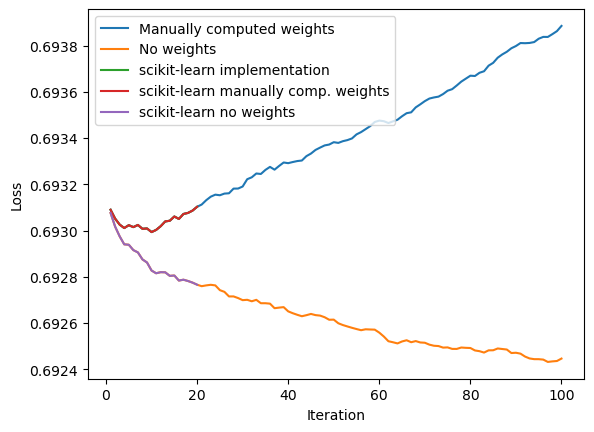

In [13]:
x_vals = np.linspace(0, 1, 100)
plt.plot(np.arange(1, len(mnl_val_losses)+1), mnl_val_losses, label="Manually computed weights")
plt.plot(np.arange(1, len(mnl_val_losses_noweights)+1), mnl_val_losses_noweights, label="No weights")
plt.plot(np.arange(1, len(skl_model['HGB'].validation_score_[1:])+1), (-1)*np.array(skl_model['HGB'].validation_score_[1:]), label="scikit-learn implementation")
plt.plot(np.arange(1, len(skl_losses)+1), skl_losses, label="scikit-learn manually comp. weights")
plt.plot(np.arange(1, len(skl_losses_noweights)+1), skl_losses_noweights, label="scikit-learn no weights")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.savefig("./sklearn_val_loss_compare.pdf")
plt.show()
plt.close()

Check for 80%/20% train/val split (there should be tiny differences due to the computation of the weights)

In [14]:
# 50% validation split
seed = 42
val_frac = 0.2
x_full = np.concatenate([x_train, x_val])
y_full = np.concatenate([y_train, y_val])
skl_hgb = HistGradientBoostingClassifier(
    max_bins=127, class_weight="balanced", max_iter=100,
    early_stopping=True, validation_fraction=val_frac,
    random_state=seed)
skl_steps = [('scaler', StandardScaler()), ('HGB', skl_hgb)]
skl_model = HGBPipeline(steps=skl_steps)

# fit model
skl_model.fit(x_full, y_full)

HGBPipeline(steps=[('scaler', StandardScaler()),
                   ('HGB',
                    HistGradientBoostingClassifier(class_weight='balanced',
                                                   early_stopping=True,
                                                   max_bins=127,
                                                   random_state=42,
                                                   validation_fraction=0.2))])

In [15]:
x_train_skl, x_val_skl, y_train_skl, y_val_skl = train_test_split(
    x_full, y_full, test_size=val_frac, stratify=y_full, random_state=skl_model['HGB']._random_seed
    )

mnl_hgb = HistGradientBoostingClassifier(max_bins=127, class_weight="balanced", max_iter=100,
                                         early_stopping=False, random_state=skl_model['HGB'].random_state)
mnl_steps = [('scaler', StandardScaler()), ('HGB', mnl_hgb)]
mnl_model = HGBPipeline(steps=mnl_steps)

# fit model
mnl_model.fit(x_train_skl, y_train_skl)

# get losses
mnl_val_losses = get_losses(mnl_model, x_val_skl, y_val_skl, compute_weights=True)
mnl_val_losses_noweights = get_losses(mnl_model, x_val_skl, y_val_skl, compute_weights=False)

In [16]:
# To mimic scikit-learn implementation, we need to compute the class weights
# based on the full dataset, then assign sample weights to the validation set
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_full), y=y_full
    )

sample_weights = ((np.ones(y_val_skl.shape) - y_val_skl)*class_weights[0]
                    + y_val_skl*class_weights[1])

# Compute log loss using sample weights
losses = []
for pred in skl_model.staged_predict_proba(x_val_skl):
    losses.append(log_loss(y_val_skl, pred[:, 1], sample_weight=sample_weights))

skl_losses = np.array(losses)

# Compute log loss without sample weights
losses = []
for pred in skl_model.staged_predict_proba(x_val_skl):
    losses.append(log_loss(y_val_skl, pred[:, 1]))

skl_losses_noweights = np.array(losses)

Plot validation losses and save under different filename for the 80%/20% case

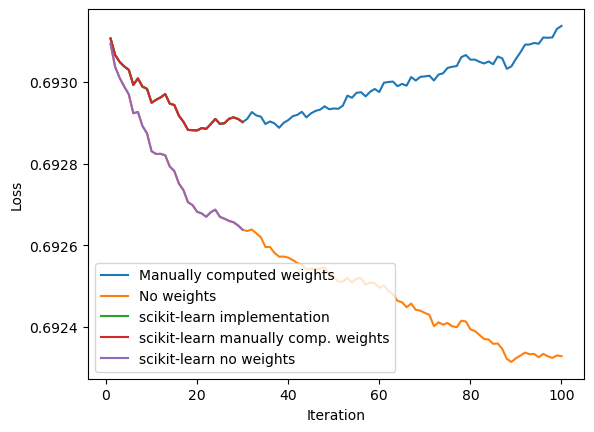

In [18]:
x_vals = np.linspace(0, 1, 100)
plt.plot(np.arange(1, len(mnl_val_losses)+1), mnl_val_losses, label="Manually computed weights")
plt.plot(np.arange(1, len(mnl_val_losses_noweights)+1), mnl_val_losses_noweights, label="No weights")
plt.plot(np.arange(1, len(skl_model['HGB'].validation_score_[1:])+1), (-1)*np.array(skl_model['HGB'].validation_score_[1:]), label="scikit-learn implementation")
plt.plot(np.arange(1, len(skl_losses)+1), skl_losses, label="scikit-learn manually comp. weights")
plt.plot(np.arange(1, len(skl_losses_noweights)+1), skl_losses_noweights, label="scikit-learn no weights")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("./sklearn_val_loss_compare8020.pdf")
plt.show()
plt.close()

Finally, we investigate how the performance in terms of SIC changes when choosing models based on weighted vs non-weighted validation loss:

Best iteration: 89, unweighted val loss: 0.6923, weighted val loss: 0.6930
Best iteration: 20, unweighted val loss: 0.6927, weighted val loss: 0.6929


/beegfs/desy/user/loeschet/treebased_ad/treebased_ad/plot_utils.py:29: RuntimeWarning: divide by zero encountered in true_divide
  multi_sics = multi_tprs/np.sqrt(multi_fprs)
/beegfs/desy/user/loeschet/treebased_ad/treebased_ad/plot_utils.py:29: RuntimeWarning: invalid value encountered in true_divide
  multi_sics = multi_tprs/np.sqrt(multi_fprs)
/beegfs/desy/user/loeschet/anaconda3/envs/hgb_env/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/beegfs/desy/user/loeschet/treebased_ad/treebased_ad/plot_utils.py:39: RuntimeWarning: divide by zero encountered in true_divide
  (1/np.sqrt(median_fprs*y_test[y_test == 0].shape[0])) < max_rel_err


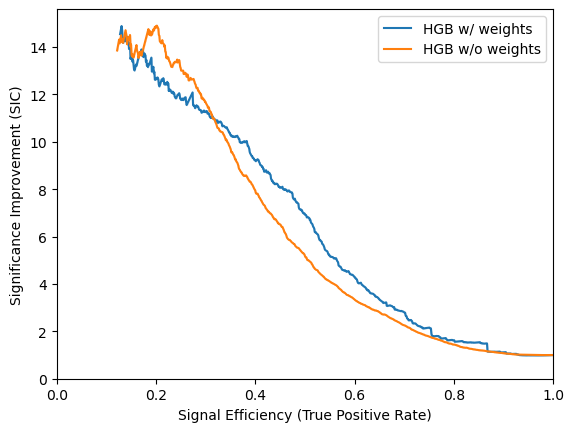

In [32]:
# Get TPRs and FPRs for all ensembles
preds_noweights = preds_from_optimal_iter(mnl_model, x_val_skl, y_val_skl, x_test, compute_weights=False)
preds_withweights = preds_from_optimal_iter(mnl_model, x_val_skl, y_val_skl, x_test, compute_weights=True)
tpr_vals_noweights, fpr_vals_noweights = multi_roc_sigeffs(preds_noweights.reshape((1, -1)), y_test)
tpr_vals_withweights, fpr_vals_withweights = multi_roc_sigeffs(preds_withweights.reshape((1, -1)), y_test)

# Plot SIC curve comparison: with and without validation weights
plot_sic_curve_comparison(
    [tpr_vals_withweights, tpr_vals_noweights], [fpr_vals_withweights, fpr_vals_noweights], y_test,
    "./hgb_sic_curve_weightcompare.pdf", labels=["HGB w/ weights", "HGB w/o weights"],
    xlabel="Signal Efficiency (True Positive Rate)", ylabel="Significance Improvement (SIC)",
    max_rel_err=0.2)

**Discussion of results of study 1.:**

It seems that the `scikit-learn` implementation does the right thing: It also correctly applies weights to the validation set. One drawback is that weights are computed based on the full dataset and are not re-computed with respect to the validation set. However, it seems that this has no practical impact (probably only when the validation fraction is super small, which should not be done anyway).

Another drawback using the `scikit-learn` implementation is that the preprocessing using `Pipeline` does not work as we would like: The scaling is done based on the full dataset, while we would like to have it for the training set only. However, as long as the training fraction is large enough, this too shouldn't make much of a difference (as can be seen from the plots). Overall, we see that our implementation and the `scikit-learn` implementation coincide. Thus, we can continue with our implementation for further studies.

Interestingly, there doesn't seem an impact on the final performance (in terms of max. SIC) whether we're choosing based on weighted or unweighted val. loss. This already hints at the validation loss not being an optimal metric for model selection, which we'll further investigate in study 2. However, the advantage of applying the weights is that we get a valid minimum, enabling early stopping techniques and thus a way faster training.

## Study 2.: Test whether validation loss is a good metric for model selection
### Study 2.1.: Study the correlation between max. SIC and validation loss of individual models of a single ensemble

In [20]:
# Load data from LHCO R&D dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_lhco_rd("./lhco_rd")

# How often to re-run the entire ensemble training procedure
num_runs = 1

# How many models constitute a single ensemble
ensembles_per_model = 10

max_iters = 100

compute_val_weights = True

# Get predictions of all ensembles
full_predictions, full_losses, models = train_histgradboost_multi(
    x_train, y_train, x_val, y_val, x_test, y_test,
    num_runs=num_runs, ensembles_per_model=ensembles_per_model, max_iters=max_iters,
    compute_val_weights=compute_val_weights, cv_mode="random",
    save_ensemble_preds=True)

numpy_losses = loss_ndarray_from_dict(full_losses)

full_train_losses = numpy_losses["train_loss"]
full_val_losses = numpy_losses["val_loss"]
full_test_losses = numpy_losses["test_loss"]

# Get TPRs and FPRs for all ensembles
tpr_vals_noG, fpr_vals_noG = multi_roc_sigeffs(full_predictions, y_test)

Run 1/1
Best iteration: 9, unweighted val loss: 0.6928, weighted val loss: 0.6930
Best iteration: 7, unweighted val loss: 0.6929, weighted val loss: 0.6930
Best iteration: 8, unweighted val loss: 0.6928, weighted val loss: 0.6930
Best iteration: 10, unweighted val loss: 0.6929, weighted val loss: 0.6930
Best iteration: 17, unweighted val loss: 0.6927, weighted val loss: 0.6930
Best iteration: 9, unweighted val loss: 0.6928, weighted val loss: 0.6930
Best iteration: 9, unweighted val loss: 0.6928, weighted val loss: 0.6930
Best iteration: 6, unweighted val loss: 0.6929, weighted val loss: 0.6930
Best iteration: 12, unweighted val loss: 0.6928, weighted val loss: 0.6930
Best iteration: 9, unweighted val loss: 0.6928, weighted val loss: 0.6930
Saving full predictions as ./ensemble_preds_run0.npy


For this study, we use the single ensemble model from the previous cell. We compute the maximum SIC value of each individual model at each iteration and plot it together with the respective validation loss.

In [21]:
# Necessary functions to conduct this study
def get_preds_from_iters(x, model):
    preds = model.staged_predict_proba(x)
    for i, pred in enumerate(preds):
        tmp_preds = pred[:, 1].reshape((1, -1))
        if i == 0:
            all_preds = tmp_preds
        else:
            all_preds = np.vstack([all_preds, tmp_preds])
    
    return all_preds

def get_sics_from_iters(x_test, y_test, model, max_rel_err=0.2):
    all_preds = get_preds_from_iters(x_test, model)
    
    all_tprs, all_fprs = multi_roc_sigeffs(all_preds, y_test)
    
    all_sics = all_tprs/np.sqrt(all_fprs)
    all_sics[~np.isfinite(all_sics)] = 0
    
    
    masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err
    masked_sics = np.ma.array(all_sics, mask=~masks)
    max_sics = masked_sics.max(axis=1).data
    
    return max_sics

def get_full_test_sics(x_test, y_test, models, max_rel_err=0.2):
    for i in range(len(models)):
        print(f"Currently running model: {i+1}/{len(models)}")
        tmp_sics = get_sics_from_iters(x_test, y_test, models[i], max_rel_err=max_rel_err)
        tmp_sics = tmp_sics.reshape((1, -1))
        if i == 0:
            full_sics = tmp_sics
        else:
            full_sics = np.vstack((full_sics, tmp_sics))
    
    return full_sics

In [22]:
# Get max. SICs for each individual model in the ensemble, for each iteration
# NOTE: This can take a while (~30 minutes)
full_sics = get_full_test_sics(x_test, y_test, models[0])

Currently running model: 1/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 2/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 3/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 4/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 5/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 6/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 7/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 8/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 9/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


Currently running model: 10/10


/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:18: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/2931898802.py:22: RuntimeWarning: divide by zero encountered in true_divide
  masks = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < max_rel_err


For each model inside a single ensemble, make a plot of the validation loss and the maximum SIC (based on signal vs. BG labels of test set) vs. training/boosting iterations

In [23]:
for i in range(full_sics.shape[0]):
    fig, ax = plt.subplots()
    xvals = np.arange(1, full_sics.shape[1]+1)
    line1, = ax.plot(xvals, full_val_losses[0][i], label="val. loss", color="blue")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Validation Loss")
    ax2 = ax.twinx()
    line2, = ax2.plot(xvals, full_sics[i], label="max. SIC", color="orange")
    ax2.set_ylabel("Significance Improvement (SIC)")
    ax2.set_ylim(0, 20)
    ax2.legend(handles=[line1, line2], loc="upper right")
    plt.savefig(f"./val_loss_max_sic_compare_run{i}.pdf", bbox_inches="tight")
    plt.close()

### Study 2.2: Look at **ensemble** SIC and (summed) validation loss at each iteration

We also run a similar study as the previous one for the *ensemble*: We compute the sum of the validation losses over all models in the ensemble and plot it with the maximum SIC values of the *ensemble* at each iteration (i.e. instead of taking the mean of the min val. loss model predictions, we take the mean of the model predictions at each iteration). For comparison, we also plot a line of the max SIC of the ensemble model where for each individual model the minimum val. loss iteration was selected.

In [24]:
# First, we get the test predictions for each model at each iteration and stack them
for idx, model in enumerate(models[0]):
    print(f"Working on model: {idx+1}/{len(models[0])}")
    tmp_preds = get_preds_from_iters(x_test, model)
    tmp_preds = tmp_preds.reshape((1, tmp_preds.shape[0], -1))
    
    if idx == 0:
        all_preds = tmp_preds
    else:
        all_preds = np.vstack([all_preds, tmp_preds])

print("Done!")

Working on model: 1/10
Working on model: 2/10
Working on model: 3/10
Working on model: 4/10
Working on model: 5/10
Working on model: 6/10
Working on model: 7/10
Working on model: 8/10
Working on model: 9/10
Working on model: 10/10
Done!


In [25]:
# Loop over all iterations and at each point take mean predictions and compute
# max SIC (including cut w.r.t. relative error as usual)
max_sic_list = []
for i in range(all_preds.shape[1]):
    print(f"Working on iteration {i+1}/{all_preds.shape[1]}")
    iter_preds = all_preds[:, i].mean(axis=0)
    iter_tprs, iter_fprs = multi_roc_sigeffs(iter_preds.reshape((1, -1)), y_test)
    iter_sics = iter_tprs/np.sqrt(iter_fprs)
    iter_sics = iter_sics.flatten()
    iter_sics[~np.isfinite(iter_sics)] = 0
    mask = (1/np.sqrt(iter_fprs.flatten()*y_test[y_test==0].shape[0])) < 0.2
    max_sic_list.append(iter_sics[mask].max())

max_sic_list = np.array(max_sic_list)

Working on iteration 1/100


/tmp/ipykernel_89345/2131551562.py:8: RuntimeWarning: divide by zero encountered in true_divide
  iter_sics = iter_tprs/np.sqrt(iter_fprs)
/tmp/ipykernel_89345/2131551562.py:8: RuntimeWarning: invalid value encountered in true_divide
  iter_sics = iter_tprs/np.sqrt(iter_fprs)
/tmp/ipykernel_89345/2131551562.py:11: RuntimeWarning: divide by zero encountered in true_divide
  mask = (1/np.sqrt(iter_fprs.flatten()*y_test[y_test==0].shape[0])) < 0.2


Working on iteration 2/100
Working on iteration 3/100
Working on iteration 4/100
Working on iteration 5/100
Working on iteration 6/100
Working on iteration 7/100
Working on iteration 8/100
Working on iteration 9/100
Working on iteration 10/100
Working on iteration 11/100
Working on iteration 12/100
Working on iteration 13/100
Working on iteration 14/100
Working on iteration 15/100
Working on iteration 16/100
Working on iteration 17/100
Working on iteration 18/100
Working on iteration 19/100
Working on iteration 20/100
Working on iteration 21/100
Working on iteration 22/100
Working on iteration 23/100
Working on iteration 24/100
Working on iteration 25/100
Working on iteration 26/100
Working on iteration 27/100
Working on iteration 28/100
Working on iteration 29/100
Working on iteration 30/100
Working on iteration 31/100
Working on iteration 32/100
Working on iteration 33/100
Working on iteration 34/100
Working on iteration 35/100
Working on iteration 36/100
Working on iteration 37/100


Plot Max SICs at each iteration vs iteration:

In [26]:
# Sum validation losses of all individual models
summed_val_losses = full_val_losses[0].sum(axis=0)

# Get max SIC for min val loss model
sics_noG = tpr_vals_noG.flatten()/np.sqrt(fpr_vals_noG.flatten())
sics_noG[~np.isfinite(sics_noG)] = 0
mask = (1/np.sqrt(fpr_vals_noG.flatten()*y_test[y_test==0].shape[0])) < 0.2
max_min_val_loss_sic = np.max(sics_noG[mask])
print(f"Maximum SIC using all models at minimum validation loss: {max_min_val_loss_sic:.2f}")

Maximum SIC using all models at minimum validation loss: 15.45


/tmp/ipykernel_89345/1456859742.py:5: RuntimeWarning: divide by zero encountered in true_divide
  sics_noG = tpr_vals_noG.flatten()/np.sqrt(fpr_vals_noG.flatten())
/tmp/ipykernel_89345/1456859742.py:5: RuntimeWarning: invalid value encountered in true_divide
  sics_noG = tpr_vals_noG.flatten()/np.sqrt(fpr_vals_noG.flatten())
/tmp/ipykernel_89345/1456859742.py:7: RuntimeWarning: divide by zero encountered in true_divide
  mask = (1/np.sqrt(fpr_vals_noG.flatten()*y_test[y_test==0].shape[0])) < 0.2


Do the plot of summed validation loss of all individual models ("ensemble val. loss") as well as the max. ensemble SIC at each iteration. Also plot max. SIC for ensemble at the respective minimum validation loss iteration (which is our current "default").

In [27]:
fig, ax = plt.subplots()
xvals = np.arange(1, 101)
line1, = ax.plot(xvals, summed_val_losses, label="Summed val losses", color="blue")
ax.set_xlabel("Iteration")
ax.set_ylabel("Summed validation Loss")
ax2 = ax.twinx()
line3, = ax2.plot(xvals, max_sic_list, label="max. SICs", color="orange")
line4, = ax2.plot([0, np.max(xvals)+1], [max_min_val_loss_sic]*2, linestyle="dashed", color="green", label="max. SIC of min val. loss models")
ax2.set_ylabel("Significance Improvement (SIC)")
#ax2.set_ylim(0, 20)
ax2.legend(handles=[line1, line3, line4], loc="lower right")
plt.savefig(f"./ensemble_val_loss_max_sic_compare.pdf", bbox_inches="tight")
plt.close()

## Study 2.3: Repeat previous study, but for each model in the ensemble take a **random** iteration

We run a very similar study as the ensebmle study in 2.2., but instead of computing the SIC at each iteration, we randomly choose an iteration for each of the models to compute the ensemble SIC with. We also compute the respective sum of the val loss for this random selection.

In [28]:
num_trials = 100
random_val_losses = []
for i in range(num_trials):
    # Get 10 random integers in the region from 0 to 99
    rng = np.random.RandomState(seed=i+1)
    selected_iters = rng.randint(0, 100, size=(10,))
    tmp_val_loss = 0
    for idx, tmp_iter in enumerate(selected_iters):
        tmp_preds = all_preds[idx, tmp_iter].reshape((1, -1))
        tmp_val_loss += full_val_losses[0][idx][tmp_iter]
        if idx == 0:
            random_preds = tmp_preds
        else:
            random_preds = np.vstack([random_preds, tmp_preds])
    
    random_val_losses.append(tmp_val_loss)
    mean_preds = random_preds.mean(axis=0).reshape((1, -1))
    
    if i==0:
        all_mean_preds = mean_preds
    else:
        all_mean_preds = np.vstack([all_mean_preds, mean_preds])

# Get max. SIC values for all random ensembles
all_tprs, all_fprs = multi_roc_sigeffs(all_mean_preds, y_test)
all_sics = all_tprs/np.sqrt(all_fprs)
all_sics[~np.isfinite(all_sics)] = 0

mask = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < 0.2
masked_sics = np.ma.array(all_sics, mask=~mask)
max_rand_sics = masked_sics.max(axis=1)
random_val_losses = np.array(random_val_losses)

/tmp/ipykernel_89345/1772460167.py:26: RuntimeWarning: divide by zero encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/1772460167.py:26: RuntimeWarning: invalid value encountered in true_divide
  all_sics = all_tprs/np.sqrt(all_fprs)
/tmp/ipykernel_89345/1772460167.py:29: RuntimeWarning: divide by zero encountered in true_divide
  mask = (1/np.sqrt(all_fprs*y_test[y_test==0].shape[0])) < 0.2


Do the same plot as before, now for the randomly selected iterations:

In [29]:
sorted_indices = np.argsort(random_val_losses)

fig, ax = plt.subplots()
xvals = np.arange(1, 101)
line1, = ax.plot(xvals, random_val_losses[sorted_indices], label="Summed val losses", color="blue")
ax.set_xlabel("Trial no. (sorted by val. loss)")
ax.set_ylabel("Summed validation Loss")
ax2 = ax.twinx()
line3, = ax2.plot(xvals, max_rand_sics[sorted_indices], label="max. SICs", color="orange")
line4, = ax2.plot([0, np.max(xvals)+1], [max_min_val_loss_sic]*2, linestyle="dashed", color="green", label="max. SIC of min val. loss models")
ax2.set_ylabel("Significance Improvement (SIC)")
#ax2.set_ylim(0, 20)
ax2.legend(handles=[line1, line3, line4], loc="lower right")
plt.savefig(f"./random_ensemble_val_loss_max_sic_compare.pdf", bbox_inches="tight")
plt.close()

## Study 2.4.: Study validation loss as metric for *different* tree-based algorithms


In [ ]:
# TODO

**Discussion of Results of study 2.:**

We have seen that for individual models, the maximum SIC value and the validation losses are not correlated. Also for the ensemble, we have seen that no strong correlation can be observed. However, it can clearly be seen that the very first iterations of the entire ensemble perform consistently worse than higher iterations. After a few iterations, the ensemble performance reaches a "plateau", at which the max. SIC starts to randomly jump around a similar value. The maximum SIC of the minimum validation loss ensemble is typically also in the plateau. We have seen cases where it is amongst the best iteration ensembles but also cases where it is more on the lower end.

In the random ensemble, we have seen that also when taking random iterations this behavior doesn't change. The maximum SIC value still jumps around a similar value (typically around 15), independent of the summed validation loss of the randomly chosen ensemble. Therefore, the (ensemble) validation loss does not seem to be a good model-agnostic predictor of the final signal-vs-background performance. However, in practice one can still use the minimum validation loss approach, since it allows for efficient training due to the availability of early stopping, while still guaranteeing to be in the optimal performance plateau, as we have seen in this study. 